## Install Preprocessing Library

Create an environment with Python >= 3.11 to avoid conflicts

In [ ]:
git clone https://github.com/GRUNECO/eeg_harmonization.git
cd eeg_harmonization
pip install -r requirements.txt #Install dependencies
pip install -e . #Install sovaharmony harmonization pipeline


There are loads of dependencies to install so please wait

In [1]:
import sovaharmony
from sovaharmony.preprocessing import harmonize

# Other Libraries

If desired, install scorEpochs to quantify epoch quality (i.e., select best quality epochs)

In [ ]:
!git clone https://github.com/Scorepochs-tools/scorepochs_py

import os
print(os.listdir("C:/Users/data_analysis/scorepochs_py/"))
import sys
sys.path.append("C:/Users/data_analysis/scorepochs_py/")

from scorepochs import scorEpochs


['.git', 'COPYING', 'README.md', 'scorepochs.py', 'scorEpochs_demo.ipynb']


In [ ]:
import os
print(os.listdir("C:/Users/data_analysis/scorepochs_py/"))
import sys
sys.path.append("C:/Users/data_analysis/scorepochs_py/")

from scorepochs import scorEpochs

['.git', 'COPYING', 'README.md', 'scorepochs.py', 'scorEpochs_demo.ipynb', '__pycache__']


In [ ]:
import os
import mne
import seaborn as sns
import pandas as pd
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report, get_entities_from_fname
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import sovaharmony
from sovaharmony.preprocessing import harmonize

import bids
from pyprep.prep_pipeline import PrepPipeline
from mne.datasets.eegbci import standardize
import cmasher as cmr
import scipy as sp
import fooof
from fooof.analysis import get_band_peak_fm
from fooof import FOOOF, FOOOFGroup
from fooof.bands import Bands
from fooof.objs import combine_fooofs
from fooof.utils import trim_spectrum
from fooof.analysis.error import compute_pointwise_error_fm
import antropy as ant
import yasa
import autogluon
from scorepochs import scorEpochs

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, balanced_accuracy_score, accuracy_score, precision_recall_curve

import mne_connectivity
from mne_connectivity.viz import plot_sensors_connectivity

# Preprocessing

## CAU-EEG (Korea)

1) DOWNLOAD caueeg_bids.rar from Drive


2) Just change here the input_path



NB: SOVAHARMONY REQUIRES USE UPPERCASE FOR CHANNEL NAMES (if using with other dataset, take this into consideration)

In [5]:
THE_DATASET={
    'name':'korea',
    'input_path':'C:/Users/sesam_analysis/Desktop/caueeg_bids',
    'layout':{'extension':'.vhdr','suffix':'eeg', 'task':'eyesClosed','return_type':'filename'},
       'args':{'line_freqs':[60]},
        'group_regex':None,
        'events_to_keep':None,
        'run-label': '',
        'channels':['FP1', 'F3', 'C3', 'P3', 'O1', 'FP2', 'F4', 'C4', 'P4', 'O2', 'F7', 'T3', 'T5', 'F8', 'T4', 'T6', 'FZ', 'CZ', 'PZ'],        
        'spatial_filter':None}

In [ ]:
%%capture
sovaharmony.preprocessing.harmonize(THE_DATASET, fast_mode=False)

# Inspection

Inspect number of epochs

##### CAUEEG - Korea #####

In [ ]:
korea={
'layout':{'extension':'.fif', 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['FP1', 'F3', 'C3', 'P3', 'O1', 'FP2', 'F4', 'C4', 'P4', 'O2', 'F7', 'T3', 'T5', 'F8', 'T4', 'T6', 'FZ', 'CZ', 'PZ'],
    'path':'D:/data_analysis/eeg_datasets/bids/korea/'
}


#Path of the BIDS folder
bids_root = 'D:/data_analysis/eeg_datasets/bids/korea/'
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'eyesClosed' 

DATASET=korea #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None), derivatives=True)
eegs = layout.get(**layoutd)
eegs = [k for k in eegs if 'eyesClosed_desc-reject' in k]

print(len(eegs))

1328


In [ ]:
%%time
%%capture
dict_list = []

for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')
    
    epochs = mne.read_epochs(eeg_file, preload = True)
    features = {}
    features['center'] = 'korea'
    features['subject'] = ('k_' + subject)
    features['channels'] = epochs.ch_names
    features['num_ch'] = len(epochs.ch_names)
    features['epoch_num'] = epochs.get_data().shape[0]
    features['sfreq'] = epochs.info['sfreq']
    dict_list.append(features)
description = pd.DataFrame(dict_list)
description['min_epochs'] = np.min(description['epoch_num'])

description.to_csv('D:/data_analysis/eeg_datasets/bids/korea/derivatives/sovaharmony/inspection.csv', index=False)

Wall time: 23.2 s


# Feature Extraction

In [ ]:
korea={
'layout':{'extension':'.fif', 'suffix':'eeg', 'return_type':'filename'},
    'ch_names':['FP1', 'F3', 'C3', 'P3', 'O1', 'FP2', 'F4', 'C4', 'P4', 'O2', 'F7', 'T3', 'T5', 'F8', 'T4', 'T6', 'FZ', 'CZ', 'PZ'],
    'path':'D:/data_analysis/eeg_datasets/bids/korea/'
}

#Path of the BIDS folder
bids_root = 'D:/data_analysis/eeg_datasets/bids/korea/'
#Seleccionar solo EEG
datatype = 'eeg'
suffix = 'eeg'

#Tarea
task = 'eyesClosed' 

DATASET=korea #DEFINE DATASET

layoutd = DATASET.get('layout', None)

layout = bids.BIDSLayout(DATASET.get('path', None), derivatives=True)
eegs = layout.get(**layoutd)
eegs = [k for k in eegs if 'eyesClosed_desc-reject' in k]

print(len(eegs))

1328


In [ ]:
%%capture
## Entropy ###

dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    mapping = {'T3': 'T7', 'T4': 'T8', 'T5': 'P7', 'T6': 'P8'}
    epochs.rename_channels(mapping)
    standardize(epochs) #standardize ch_names
    keep = ['Fp1','Fp2', 'F3','F4', 'Fz', 'F7', 'F8',  'C3', 'C4', 'Cz' , 'T7','T8',  'P7' ,'P8', 'P3','P4', 'Pz', 'O1', 'O2']
    epochs.pick_channels(keep)
    epochs = epochs.filter(l_freq=1, h_freq=45) #bandpassing 1-30Hz
    downsample = 128 #downsampling to 128Hz
    epochs.resample(downsample)
    nepochs,nchannels,npoints = epochs._data.shape
    if nepochs >= 20:
        clean_epochs = epochs
         # get shape of clean epoched data and reshape to fit scorEpochs input requirements
        continuous_signal = np.reshape(clean_epochs,(nchannels,nepochs*npoints),order='F') # final shape nchannels, npoints
        t_ep = 5 #epoch length
        fs = downsample #sampling freq
        freq = [1, 30] #interest freq
        cfg = {'freqRange':freq, 'fs':fs, 'windowL':t_ep}
        idx_best, epoch, scores = scorEpochs(cfg, continuous_signal)
        # Get the top 20 epoch indices from idx_best
        best_20_indices = idx_best[:20]
        # Use these indices to extract the best 20 epochs from clean_epochs
        best_20_epochs = epochs[best_20_indices]
        # Optionally, you can concatenate the epochs (though it's not strictly necessary)
        epochs_c = mne.concatenate_epochs([best_20_epochs], add_offset=False, on_mismatch='raise', verbose=None)
        
        epochs = epochs_c
        epochs.set_montage("standard_1005")
        nepochs,nchannels,npoints = epochs._data.shape
        correct_channels = keep
        epochs.reorder_channels(correct_channels)
        channels = epochs.info['ch_names']
        srate = downsample
        for ch,ch_label in enumerate(channels):
            for ep in range(nepochs):
                features = {}
                features['center'] = 'korea'
                features['subject'] = ('kor_' + subject)
                features['channel'] = ch_label
                features['epoch'] = ep
                features['permutation'] = ant.perm_entropy(epochs.get_data()[ep,ch,:], normalize=True)
                features['sample'] = ant.sample_entropy(epochs.get_data()[ep,ch,:])
                features['approximate'] = ant.app_entropy(epochs.get_data()[ep,ch,:])
                features['svd_ent'] = ant.svd_entropy(epochs.get_data()[ep,ch,:], order=5, normalize=True)             
                features['higuchi_fd']  = ant.higuchi_fd(epochs.get_data()[ep,ch,:])  
                features['hjort_mobility']  = (ant.hjorth_params(epochs.get_data()[ep,ch,:]))[0]
                features['hjort_complexity']  = (ant.hjorth_params(epochs.get_data()[ep,ch,:]))[1]
                features['detrended_fluct']  = ant.detrended_fluctuation(epochs.get_data()[ep,ch,:])
                features['katz_fd']  = ant.katz_fd(epochs.get_data()[ep,ch,:])
                features['petrosian_fd']  = ant.petrosian_fd(epochs.get_data()[ep,ch,:])
                dict_list.append(features)
entropies = pd.DataFrame(dict_list)

permutation = pd.DataFrame(entropies.groupby(['center','subject', 'channel']).permutation.mean())
entropies.rename(columns = {'sample':'sample_ent'}, inplace = True)
sample_ent = pd.DataFrame(entropies.groupby(['center', 'subject', 'channel']).sample_ent.mean())
approximate = pd.DataFrame(entropies.groupby(['center', 'subject', 'channel']).approximate.mean())
svd_ent = pd.DataFrame(entropies.groupby(['center', 'subject', 'channel']).svd_ent.mean())
higuchi_fd = pd.DataFrame(entropies.groupby(['center', 'subject', 'channel']).higuchi_fd.mean())
hjort_mobility = pd.DataFrame(entropies.groupby(['center', 'subject', 'channel']).hjort_mobility.mean())
hjort_complexity = pd.DataFrame(entropies.groupby(['center', 'subject', 'channel']).hjort_complexity.mean())
detrended_fluct = pd.DataFrame(entropies.groupby(['center', 'subject', 'channel']).detrended_fluct.mean())
katz_fd = pd.DataFrame(entropies.groupby(['center', 'subject', 'channel']).katz_fd.mean())
petrosian_fd = pd.DataFrame(entropies.groupby(['center', 'subject', 'channel']).petrosian_fd.mean())

dfs = [permutation, sample_ent, approximate, svd_ent, higuchi_fd, hjort_mobility, hjort_complexity, detrended_fluct, katz_fd, petrosian_fd]
entropies_ave = pd.DataFrame(pd.concat(dfs, axis = 1)).reset_index()

entropies_ave.to_feather('D:/data_analysis/papers_alberto/cau_combat/features_data/ent_korea.feather')


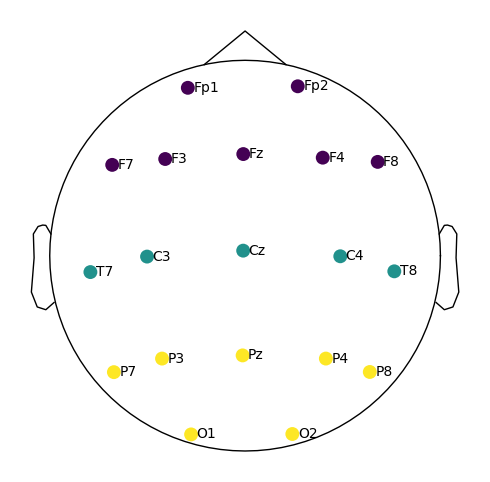

In [ ]:
anterior = ["Fp1", "Fp2", "F3", "F4", "F7", "F8", "Fz"]
central = ["T7", "T8", "C3", "C4", "Cz"]
posterior = ["P3", "P4", "P7", "P8", "Pz", "O1", "O2"]

montage = mne.channels.make_standard_montage("standard_1005")
epochs.set_montage(montage)

groups = [anterior, central, posterior]
group_indices = []  # Create a separate list to store indices

for ch_names in groups:
    indices = [epochs.ch_names.index(ch_name) for ch_name in ch_names]
    group_indices.append(indices)  # Append indices to the separate list

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the sensors
mne.viz.plot_sensors(epochs.info, ch_groups=group_indices, pointsize=100, show_names=True, linewidth=0, sphere=(0, 0.024, 0, 0.09), axes=ax)
plt.show()
# Save the figure as TIFF with 300 DPI
fig.savefig('D:/data_analysis/papers_alberto/cau_combat/figures/sensors.tiff', dpi=300, format='tiff')


Note: The 10-20 and 10-10 system share 4 channel positions but changed the name. 

Thus, in the 10-20 the electrodes T3, T4, T5, T6, correspond to the 10-10 T7, T8, P7, and P8 respectively.

https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG)


In [ ]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    mapping = {'T3': 'T7', 'T4': 'T8', 'T5': 'P7', 'T6': 'P8'}
    epochs.rename_channels(mapping)
    standardize(epochs) #standardize ch_names
    keep = ['Fp1','Fp2', 'F3','F4', 'Fz', 'F7', 'F8',  'C3', 'C4', 'Cz' , 'T7','T8',  'P7' ,'P8', 'P3','P4', 'Pz', 'O1', 'O2']
    epochs.pick_channels(keep)
    epochs = epochs.filter(l_freq=1, h_freq=45) #bandpassing 1-30Hz
    downsample = 128 #downsampling to 128Hz
    epochs.resample(downsample)
    sf = downsample
    nepochs,nchannels,npoints = epochs._data.shape
    if nepochs >= 20:
        clean_epochs = epochs
         # get shape of clean epoched data and reshape to fit scorEpochs input requirements
        continuous_signal = np.reshape(clean_epochs,(nchannels,nepochs*npoints),order='F') # final shape nchannels, npoints
        t_ep = 5 #epoch length
        fs = downsample #sampling freq
        freq = [1, 30] #interest freq
        cfg = {'freqRange':freq, 'fs':fs, 'windowL':t_ep}
        idx_best, epoch, scores = scorEpochs(cfg, continuous_signal)
        # Get the top 20 epoch indices from idx_best
        best_20_indices = idx_best[:20]
        # Use these indices to extract the best 20 epochs from clean_epochs
        best_20_epochs = epochs[best_20_indices]
        # Optionally, you can concatenate the epochs (though it's not strictly necessary)
        epochs_c = mne.concatenate_epochs([best_20_epochs], add_offset=False, on_mismatch='raise', verbose=None)        

        epochs = epochs_c
        epochs.set_montage("standard_1005")
        nepochs,nchannels,npoints = epochs._data.shape
        correct_channels = keep
        epochs.reorder_channels(correct_channels)
        channels = epochs.info['ch_names']
        freq_range_slow_theta = (4, 5.5)
        freq_range_prealpha = (5.5, 8)
        freq_range_alpha = (8, 13)
        n_epochs, n_channels, n_points = epochs._data.shape
        dominant_freqs = np.zeros(n_epochs)  # Array to store dominant frequencies for each epoch
        freq_range_df = (4, 15)

        for ch, ch_label in enumerate(channels):
            psd, freqs = mne.time_frequency.psd_array_multitaper(epochs.get_data()[:,ch,:], sfreq = sf,fmin=1, fmax=30, n_jobs=-1)
            
            freq_bins = freqs.shape[0]
            band_indices_slow_theta = np.where((freqs >= freq_range_slow_theta[0]) & (freqs < freq_range_slow_theta[1]))[0]
            band_indices_prealpha = np.where((freqs >= freq_range_prealpha[0]) & (freqs < freq_range_prealpha[1]))[0]
            band_indices_alpha = np.where((freqs >= freq_range_alpha[0]) & (freqs < freq_range_alpha[1]))[0]
            band_indices_df = np.where((freqs >= freq_range_df[0]) & (freqs < freq_range_df[1]))[0]

            # Compute the dominant frequency for each epoch within the specified range
            dominant_freqs = freqs[band_indices_df[np.argmax(psd[:, band_indices_df], axis=1)]]
            # Compute the standard deviation of dominant frequencies within the specified range across all epochs
            dom_freq = np.mean(dominant_freqs)
            dom_freq_var = np.std(dominant_freqs)

            freq_prev_slow_theta = np.sum(np.logical_and(freqs[np.argmax(psd, axis=1)] >= freq_range_slow_theta[0],freqs[np.argmax(psd, axis=1)] < freq_range_slow_theta[1])) / n_epochs
            freq_prev_prealpha = np.sum(np.logical_and(freqs[np.argmax(psd, axis=1)] >= freq_range_prealpha[0],freqs[np.argmax(psd, axis=1)] < freq_range_prealpha[1])) / n_epochs
            freq_prev_alpha = np.sum(np.logical_and(freqs[np.argmax(psd, axis=1)] >= freq_range_alpha[0],freqs[np.argmax(psd, axis=1)] < freq_range_alpha[1])) / n_epochs
            
            psd = np.median(psd,0) # get median psd vector per channel
            unc_bandpowers = yasa.bandpower_from_psd_ndarray(psd, freqs, bands=[(1, 4, 'Delta'), (4, 8, 'Theta'), (8, 13, 'Alpha'), (13, 30, 'Beta')], relative=True)
            fm = FOOOF(peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=6)
            # Initialize FOOOF object
            # Define frequency range across which to model the spectrum
            freq_range = [1, 30]
            fm.fit(freqs, psd, freq_range)   # Fit the power spectrum model
            # Define frequency bands of interest
            bands = Bands({'extalpha' : [5, 14],'beta' : [13, 30]})
            # Extract params
            betas = get_band_peak_fm(fm, bands.beta)
            extalphas = get_band_peak_fm(fm, bands.extalpha)

            aperiodic = fm.get_params('aperiodic_params')
            fit = [fm.get_params('r_squared'), fm.get_params('error')]
            features = {}
            features['center'] = 'korea'
            features['subject'] = ('kor_' + subject)
            features['channel'] = ch_label
            features['unc_delta'] = unc_bandpowers[0]
            features['unc_theta'] = unc_bandpowers[1]
            features['unc_alpha'] = unc_bandpowers[2]
            features['unc_beta'] = unc_bandpowers[3]
            features['fp_slow_theta'] = freq_prev_slow_theta
            features['fp_prealpha'] = freq_prev_prealpha
            features['fp_alpha'] = freq_prev_alpha
            features['dom_freq'] = dom_freq
            features['dom_freq_var'] = dom_freq_var
            features['beta_cf'] = betas[0]
            features['beta_pw'] = betas[1]
            features['beta_bw'] = betas[2]
            features['extalphas_cf'] = extalphas[0]
            features['extalphas_pw'] = extalphas[1]
            features['extalphas_bw'] = extalphas[2]
            features['exponent'] = aperiodic[1]
            features['offset'] = aperiodic[0]
            features['r_squared'] = fit[0]
            features['error'] = fit[1]
            # Median score for the best 20 epochs
            median_scorEpochs = np.median(scores[best_20_indices])
            # Scores of the best 20 epochs 
            all_scorEpochs = list(scores[best_20_indices])
            features['median_scorEpochs'] = median_scorEpochs
            features['all_scorEpochs'] = all_scorEpochs
            dict_list.append(features)
df = pd.DataFrame(dict_list)

df.to_feather('D:/data_analysis/papers_alberto/cau_combat/features_data/fooof_korea.feather')

In [ ]:
%%capture
dict_list = []
for eeg_file in eegs: #read and preload dataset
    subject_info = layout.parse_file_entities(eeg_file)
    session = subject_info.get('session')
    subject = subject_info.get('subject')
    bids_path = BIDSPath(subject=subject, session=session, task=task, root=bids_root, datatype='eeg')
    epochs = mne.read_epochs(eeg_file, preload = True)
    mapping = {'T3': 'T7', 'T4': 'T8', 'T5': 'P7', 'T6': 'P8'}
    epochs.rename_channels(mapping)
    standardize(epochs) #standardize ch_names    
    keep = ['Fp1','Fp2', 'F3','F4', 'Fz', 'F7', 'F8',  'C3', 'C4', 'Cz' , 'T7','T8',  'P7' ,'P8', 'P3','P4', 'Pz', 'O1', 'O2']
    epochs.pick_channels(keep)
    epochs = epochs.filter(l_freq=1, h_freq=45) #bandpassing 1-30Hz
    downsample = 128 #downsampling to 128Hz
    epochs.resample(downsample)
    sf = downsample
    nepochs,nchannels,npoints = epochs._data.shape
    if nepochs >= 20:
        clean_epochs = epochs
         # get shape of clean epoched data and reshape to fit scorEpochs input requirements
        continuous_signal = np.reshape(clean_epochs,(nchannels,nepochs*npoints),order='F') # final shape nchannels, npoints
        t_ep = 5 #epoch length
        fs = downsample #sampling freq
        freq = [1, 30] #interest freq
        cfg = {'freqRange':freq, 'fs':fs, 'windowL':t_ep}
        idx_best, epoch, scores = scorEpochs(cfg, continuous_signal)
        # Get the top 20 epoch indices from idx_best
        best_20_indices = idx_best[:20]
        # Use these indices to extract the best 20 epochs from clean_epochs
        best_20_epochs = epochs[best_20_indices]
        # Optionally, you can concatenate the epochs (though it's not strictly necessary)
        epochs_c = mne.concatenate_epochs([best_20_epochs], add_offset=False, on_mismatch='raise', verbose=None)

        epochs = epochs_c
        epochs.set_montage("standard_1005")
        nepochs,nchannels,npoints = epochs._data.shape
        correct_channels = keep
        epochs.reorder_channels(correct_channels)
        channels = epochs.info['ch_names']
        for ch,ch_label in enumerate(channels):
            psds, freqs = mne.time_frequency.psd_array_multitaper(epochs.get_data()[:,ch,:], sfreq = sf,fmin=1, fmax=30, n_jobs=-1)
            psds = np.median(psds, 0) # get median psd vector per channel
            fm = FOOOF(peak_width_limits=[1, 8], min_peak_height=0.05, max_n_peaks=6)
            # Initialize FOOOF object
            # Define frequency range across which to model the spectrum
            freq_range = [1, 30]
            fm.fit(freqs, psds, freq_range)   # Fit the power spectrum model
            osc_fit = fm._peak_fit
            psd_fit = fm.fooofed_spectrum_
            ap_fit = fm._ap_fit
            spect_flat = fm._spectrum_flat
            aperiodic = fm._spectrum_peak_rm
            for freq in freqs:
                features = {}
                features['center'] = 'korea'
                features['subject'] = ('kor_' + subject)
                features['channel'] = ch_label
                features['frequency'] = freq
                features['psd'] = np.log10(psds[freqs==freq][0])
                features['psd_fit'] = psd_fit[freqs==freq][0]
                features['osc'] = spect_flat[freqs==freq][0]            
                features['osc_fit'] = osc_fit[freqs==freq][0]
                features['ap'] = aperiodic[freqs==freq][0]
                features['ap_fit'] = ap_fit[freqs==freq][0]
                dict_list.append(features)
df = pd.DataFrame(dict_list)
df.to_feather('D:/data_analysis/papers_alberto/cau_combat/features_data/spectrum_fooof_korea.feather')

In [ ]:
def plot_channel_power(df):
    unique_participants = df['subject'].unique()
    unique_channels = df['channel'].unique()
    colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(unique_participants)))

    fig, axs = plt.subplots(figsize=(15, 8), ncols=3)

    for idx, ax in enumerate(axs):
        # Get columns to plot
        column = ['psd_fit', 'ap_fit', 'osc_fit'][idx]
        ax.set_title(column.capitalize() + ' Power')
        ax.set_xlabel('Frequency (Hz)')
        if idx == 0:
            ax.set_ylabel('Power (log10)')
        else:
            ax.set_ylabel('Power (a.u)')

        # Get channel mean for each participant
        for i, participant in enumerate(unique_participants):
            participant_df = df[df['subject'] == participant]
            participant_avg = participant_df.groupby(['frequency'])[column].mean()
            ax.plot(participant_avg.index, participant_avg.values, color=colors[i], alpha=0.2, label=None)

        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Example
plot_channel_power(df)


# Merge features & meta-data

In [ ]:
# Read the Dataset participants.tsv metadata and merge demographic variables with features 

metadata_cols = ['participant_id', 'ad_syndrome' , 'age'] # names of the metadata columns to be merged

participants_file = 'D:/data_analysis/eeg_datasets/bids/korea/participants.tsv'
participants_df = pd.read_csv(participants_file, sep="\t")
participants_df.columns= participants_df.columns.str.lower() # To set all the column names in lower case
participants_df['participant_id'] = participants_df['participant_id'].str.replace('sub-', 'kor_')  # Drop the "sub-" prefix used for BIDS standardization
participants_df = participants_df.loc[:, metadata_cols]  # Filter the DataFrame to include only the specified columns

entropies_file = 'D:/data_analysis/papers_alberto/cau_combat/features_data/ent_korea.feather'
entropies_df = pd.read_feather(entropies_file)
entropies_df.rename(columns = {'subject':'participant_id'}, inplace = True)


bandpowers_file = 'D:/data_analysis/papers_alberto/cau_combat/features_data/fooof_korea.feather'
bandpowers_df = pd.read_feather(bandpowers_file)
bandpowers_df.rename(columns = {'subject':'participant_id'}, inplace = True)

# List of channels to filter
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'F7', 'F8', 'C3', 'C4', 'Cz', 'T7', 'T8', 'P7', 'P8', 'P3', 'P4', 'Pz', 'O1', 'O2']

# Filter the DataFrame
bandpowers = bandpowers_df[bandpowers_df['channel'].isin(channels)]


korea_df = pd.DataFrame(pd.merge(participants_df, entropies_df, on=["participant_id"])) 
korea_df = pd.merge(korea_df, bandpowers, on=["participant_id", "center", "channel"])

# Full CAU dataset (n = 1300)

korea_df.to_csv('D:/data_analysis/papers_alberto/cau_combat/features_data/korea_df.csv', index=False)